In [31]:
import cv2
import numpy as np
from scipy.ndimage import binary_opening, binary_closing
import matplotlib.pyplot as plt
import math

# The position and value to hide in the 4x4 sub_image DCT
x0, y0 = 0, 0
V0 = 19

# Shuffle the order of 256 4x4 regions, each RGB channel has its own order
img_idx_list = []
for i in range(256):
    for j in range(256):
        img_idx_list.append((i, j))
np.random.seed(0)
shuffle_img_idx_list = [img_idx_list.copy(), img_idx_list.copy(), img_idx_list.copy()]
np.random.shuffle(shuffle_img_idx_list[0])
np.random.shuffle(shuffle_img_idx_list[1])
np.random.shuffle(shuffle_img_idx_list[2])

# Provided level 1 attack: noise
def gaussian_noise(img, mean=0, sigma=0.1):
    # int -> float (normalize)
    img = img / 255
    # Randomly generate Gaussian noise (float + float)
    noise = np.random.normal(mean, sigma, img.shape)
    # noise + original image
    gaussian_out = img + noise
    # All values must be between 0~1, above 1 = 1, below 0 = 0
    gaussian_out = np.clip(gaussian_out, 0, 1)
    # Original image: float -> int (0~1 -> 0~255)
    gaussian_out = np.uint8(gaussian_out*255)
    # noise: float -> int (0~1 -> 0~255)
    noise = np.uint8(noise*255)
    return gaussian_out 

# Add watermark to RGB image
# Method: Cut the image into 4x4 blocks and hide value at the corresponding position
def add_watermark(origin_img, watermark_img,shuffle_img_idx_list):
    watermark = watermark_img[17:-17,17:-17] # Only take 256x256 watermark
    watermarked_origin_img = np.empty(origin_img.shape) # Store image after watermark embedding
    for k in range(3):
        for idx, (i, j) in enumerate(img_idx_list):  
            sub_img = origin_img[4*i:4*i+4, 4*j:4*j+4, k]
            sub_img_DCT = cv2.dct(sub_img)
            w1, w2 = shuffle_img_idx_list[k][idx]
            if watermark[w1, w2] == 0:
                sub_img_DCT[x0, y0] += V0
            else:
                sub_img_DCT[x0, y0] -= V0
            watermarked_origin_img[4*i:4*i+4, 4*j:4*j+4, k] = cv2.idct(sub_img_DCT)
    return watermarked_origin_img

# Extract watermark from attacked image
def extract_watermark(attacked_img,origin_img, img_idx_list, shuffle_img_idx_list, k):
    recovery_watermark = np.full((290, 290), 0)

    for idx, (i, j) in enumerate(img_idx_list): 
        sub_attacked_img = attacked_img[4*i:4*i+4, 4*j:4*j+4, k]
        sub_attacked_img_DCT = cv2.dct(sub_attacked_img)

        sub_img = origin_img[4*i:4*i+4, 4*j:4*j+4, k]
        sub_img_DCT = cv2.dct(sub_img)
        
        
        w1, w2 = shuffle_img_idx_list[k][idx]
        if (sub_attacked_img_DCT[x0, y0] - sub_img_DCT[x0, y0]) > 0:
            recovery_watermark[17+w1, 17+w2] += 1
        else:
            recovery_watermark[17+w1, 17+w2] += 0

    recovery_watermark = np.where(recovery_watermark>=1, 0, 255)

    
    return recovery_watermark

# Calculate PSNR between two images
def psnr(img1, img2):
    mse = np.mean( (img1/255. - img2/255.) ** 2 )
    if mse < 1.0e-10:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def RGB_psnr(img1, img2):
    return (psnr(img1[:,:,0], img2[:,:,0])+psnr(img1[:,:,1], img2[:,:,1])+psnr(img1[:,:,2], img2[:,:,2]))/3

def bit_error_rate(recovery_watermark, origin_watermark):
    return 1-np.sum(recovery_watermark == origin_watermark)/(290*290)

def my_GaussianBlur(img, i, kernel_size):
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    img = np.where(img < 178  , 0, 255)
    return img

def my_binary_closing(img, i, kernel_size):
    img = binary_closing(img/255,structure = np.ones((kernel_size,kernel_size)))*255
    return img

def my_binary_opening(img, i, kernel_size):
    img = binary_opening(img/255,structure = np.ones((kernel_size,kernel_size)))*255
    return img

def merge_RGB_watermark(recovery_watermark, img):
    for i in range(290):
        for j in range(290):
            if int(recovery_watermark[0][i, j]) + int(recovery_watermark[1][i, j]) + int(recovery_watermark[2][i, j]) > 400:
                img[i, j] = 255
            else:
                img[i, j] = 0
    return img

def eliminate_edge(img):
    for i in range(-3, 3):
        for j in range(290):
            img[i, j] = 255
    for j in range(-3, 3):
        for i in range(290):
            img[i, j] = 255
    return img

PSNR: 34.70276689842265


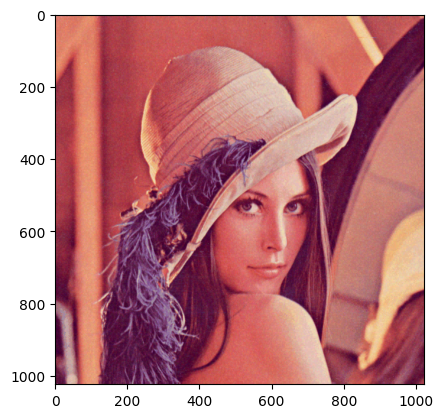

In [32]:

input_img_name = './input/lena.bmp' # 'lena.bmp'
input_watermark_name = './input/watermark.png' # 'watermark.png'
GaussianBlur_kernel_size = 9
close_kernel_size = 5
open_kernel_size = 3
cv2_img_order = "BGR"

origin_img = cv2.imread(input_img_name)
origin_img = np.float32(origin_img) # Use float type for cv2.dct

water_mark_img = cv2.imread(input_watermark_name, 0) # Read watermark image in grayscale

watermarked_origin_img =  add_watermark(origin_img, water_mark_img,shuffle_img_idx_list)
watermarked_origin_img = np.array(watermarked_origin_img, dtype=np.uint8)

output_watermarked_img_path = './output/watermarked_lena.bmp'
cv2.imwrite(output_watermarked_img_path, watermarked_origin_img)

"""Calculate PSNR between two color images""" 
PSNR = RGB_psnr(cv2.imread(output_watermarked_img_path), cv2.imread(input_img_name))
print("PSNR:", PSNR)

plt.imshow(watermarked_origin_img[:,:,[2,1,0]])
plt.show()

------------ B ------------


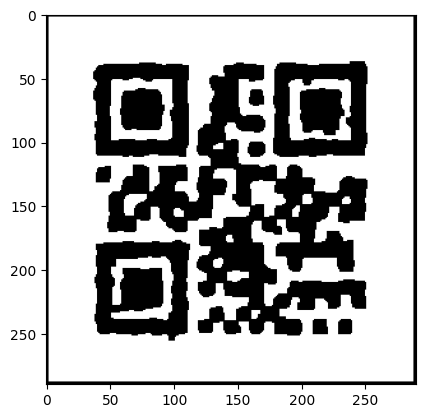

------------ G ------------


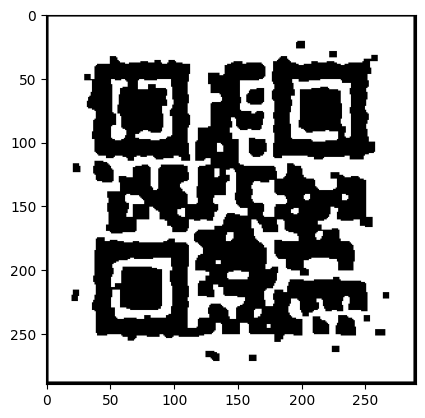

------------ R ------------


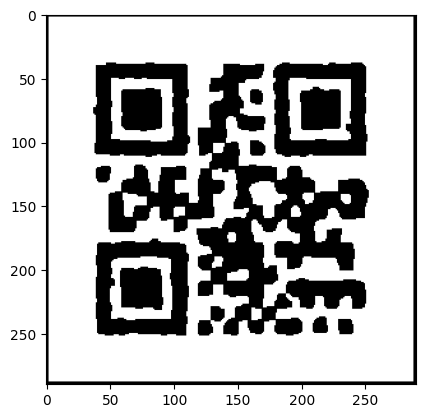

------------ after combine RGB ------------


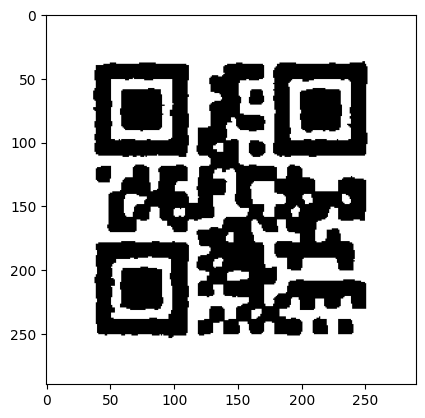

bit_error_rate 0.07149821640903686


In [34]:
"""level1 attack"""
attacked_img = cv2.imread(output_watermarked_img_path)
attacked_img = gaussian_noise(attacked_img)
attacked_img = np.float32(attacked_img) # for DCT

recovery_watermark = [[],[],[]]

for i in range(3):
    recovery_watermark[i] = np.array(extract_watermark(attacked_img, origin_img,img_idx_list, shuffle_img_idx_list, i), dtype=np.uint8)
    recovery_watermark[i] = my_GaussianBlur(recovery_watermark[i], i, kernel_size=GaussianBlur_kernel_size)
    recovery_watermark[i] = my_binary_closing(recovery_watermark[i], i, kernel_size=close_kernel_size)
    recovery_watermark[i] = my_binary_opening(recovery_watermark[i], i, kernel_size=open_kernel_size)
    print("------------", cv2_img_order[i] ,"------------")
    plt.imshow(recovery_watermark[i], cmap="gray")
    plt.show()


img_out = np.empty(recovery_watermark[0].shape)
img_out = merge_RGB_watermark(recovery_watermark, img_out)
img_out = eliminate_edge(img_out)

print("------------", "after combine RGB", "------------")
cv2.imwrite("extract_watermark_noise.png", img_out)
plt.imshow(img_out, cmap="gray")
plt.show()
print("bit_error_rate", bit_error_rate(img_out,water_mark_img))


------------ B ------------


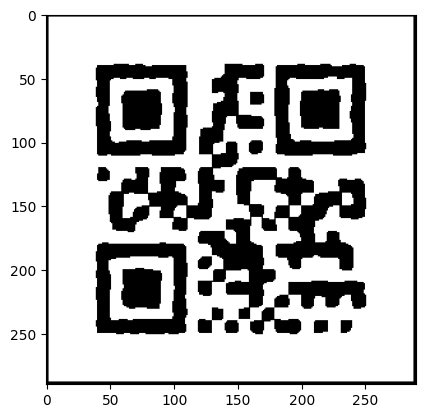

------------ G ------------


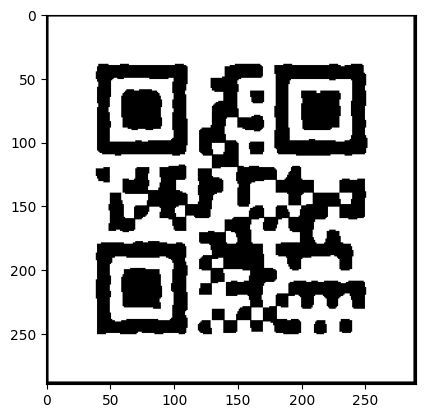

------------ R ------------


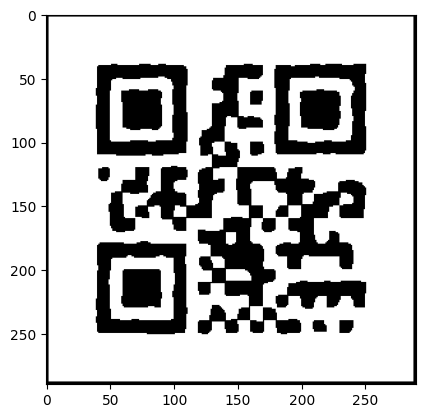

------------ after combine RGB ------------


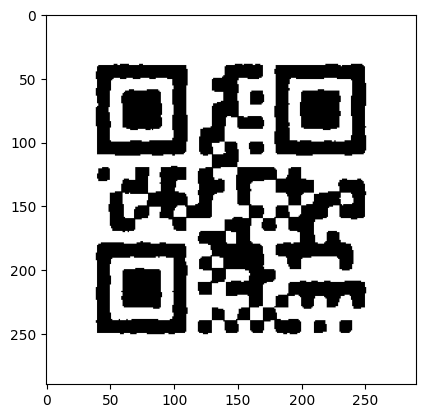

bit_error_rate 0.021688466111771665


In [38]:
"""level2 attack"""
attacked_img = cv2.imread(output_watermarked_img_path)
attacked_img = attacked_img = cv2.GaussianBlur(attacked_img, (7, 7), 2)
attacked_img = np.float32(attacked_img) # for DCT

recovery_watermark = [[],[],[]]
for i in range(3):
    recovery_watermark[i] = np.array(extract_watermark(attacked_img, origin_img,img_idx_list, shuffle_img_idx_list, i), dtype=np.uint8)
    recovery_watermark[i] = my_GaussianBlur(recovery_watermark[i], i, kernel_size=GaussianBlur_kernel_size)
    recovery_watermark[i] = my_binary_closing(recovery_watermark[i], i, kernel_size=close_kernel_size)
    recovery_watermark[i] = my_binary_opening(recovery_watermark[i], i, kernel_size=open_kernel_size)
    print("------------", cv2_img_order[i] ,"------------")
    plt.imshow(recovery_watermark[i], cmap="gray")
    plt.show()

img_out = np.empty(recovery_watermark[0].shape)
img_out = merge_RGB_watermark(recovery_watermark, img_out)
img_out = eliminate_edge(img_out)

print("------------", "after combine RGB", "------------")
cv2.imwrite("extract_watermark_blur.png", img_out)
plt.imshow(img_out, cmap="gray")
plt.show()
print("bit_error_rate", bit_error_rate(img_out,water_mark_img))


------------ B ------------


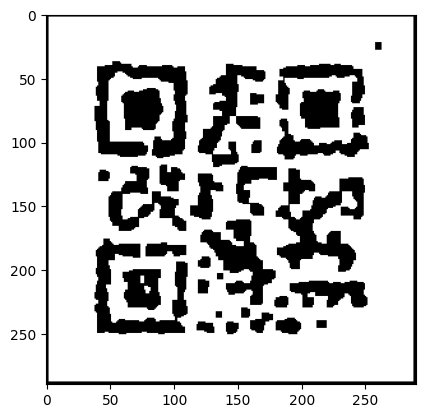

------------ G ------------


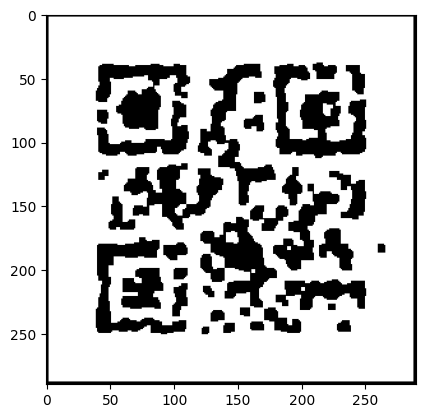

------------ R ------------


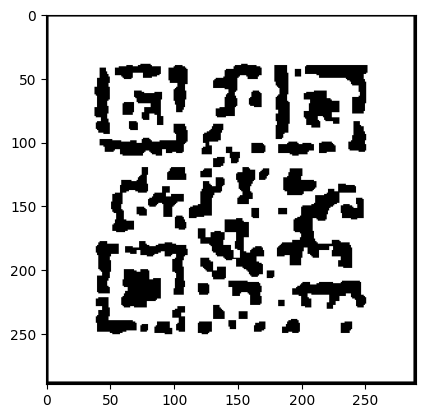

------------ after combine RGB ------------


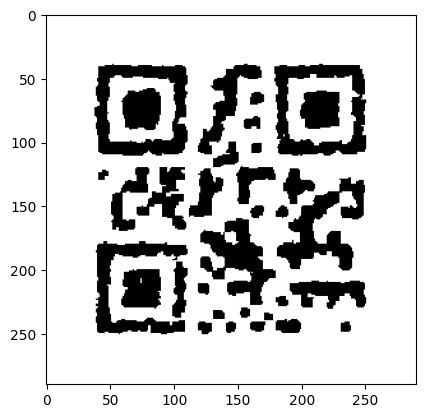

bit_error_rate 0.04967895362663499


In [37]:
"""level3 attack"""
attacked_img = cv2.imread(output_watermarked_img_path)
attacked_img = cv2.resize(attacked_img, (200, 200), interpolation=cv2.INTER_AREA)
attacked_img = cv2.resize(attacked_img, (1024, 1024))
attacked_img = np.float32(attacked_img) # for DCT

recovery_watermark = [[],[],[]]
for i in range(3):
    recovery_watermark[i] = np.array(extract_watermark(attacked_img,origin_img, img_idx_list, shuffle_img_idx_list, i), dtype=np.uint8)
    recovery_watermark[i] = my_GaussianBlur(recovery_watermark[i], i, kernel_size=GaussianBlur_kernel_size)
    recovery_watermark[i] = my_binary_closing(recovery_watermark[i], i, kernel_size=close_kernel_size)
    recovery_watermark[i] = my_binary_opening(recovery_watermark[i], i, kernel_size=open_kernel_size)
    print("------------", cv2_img_order[i] ,"------------")
    plt.imshow(recovery_watermark[i], cmap="gray")
    plt.show()


img_out = np.empty(recovery_watermark[0].shape)
img_out = merge_RGB_watermark(recovery_watermark, img_out)
img_out = eliminate_edge(img_out)

print("------------", "after combine RGB", "------------")
cv2.imwrite("extract_watermark_compress.png", img_out)
plt.imshow(img_out, cmap="gray")
plt.show()
print("bit_error_rate", bit_error_rate(img_out,water_mark_img))